# Feature Creation

This asset will be divided into two parts Data Cleansing and Feature Engineering

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import Normalizer
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190909164227-0000
KERNEL_ID = e7f00509-f411-43b2-8faa-9183bcb85590


Already check for NULL values in the IDE so we will continue with data cleansing of the data. 

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# The code was removed by Watson Studio for sharing.

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# We create a temporary view in order to call SQL queries to the spark dataframe object
df.createOrReplaceTempView("df")

### I. Data Cleansing 

A. Data Types 
   
* Are data types of columns matching their content? - Yes it does although we had to specify this as an option in the scala code to import this **.option("inferSchema","true")** 

B. Ranges 
* Does the value distribution of values in column make sense?

In [5]:
df.describe("Time","Amount","Class").show()

+-------+------------------+------------------+--------------------+
|summary|              Time|            Amount|               Class|
+-------+------------------+------------------+--------------------+
|  count|            284807|            284807|              284807|
|   mean|        94813.8596|  88.3496192509508|0.001727485630620034|
| stddev|47488.145954566906|250.12010924018736| 0.04152718963546528|
|    min|                 0|               0.0|                   0|
|    max|            172792|          25691.16|                   1|
+-------+------------------+------------------+--------------------+



Text(0.5, 1.0, 'Distribution of Transaction Amount')

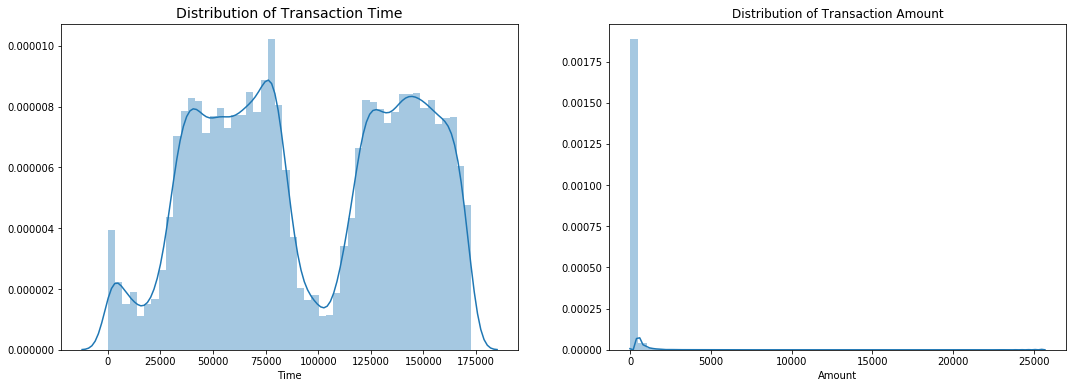

In [6]:
fig , ax = plt.subplots(1,2, figsize=(18,6))
sns.distplot(df_pd["Time"],ax=ax[0])
ax[0].set_title('Distribution of Transaction Time', fontsize=14)


sns.distplot(df_pd["Amount"],ax = ax[1])
ax[1].set_title('Distribution of Transaction Amount')


The period of our dataset is two days. The distribution of our transactions are adequately grouped to peak at the day time and go down during the night time.

(0, 200)

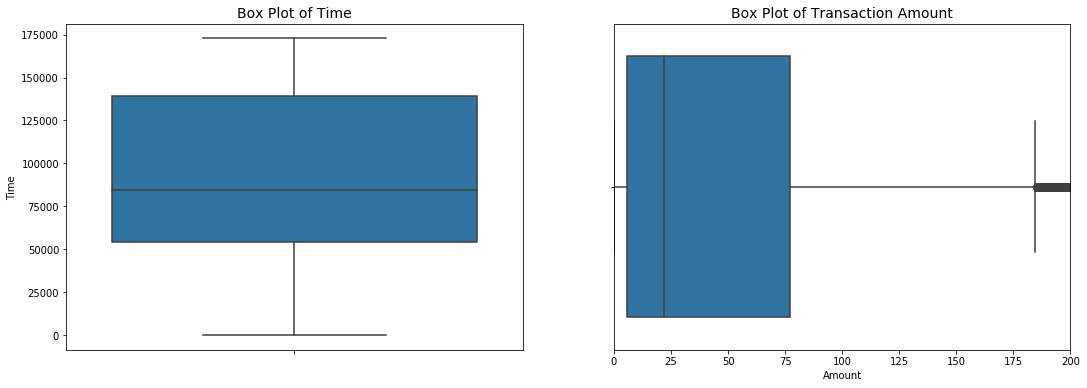

In [7]:
fig1, ax1 = plt.subplots(1,2, figsize=(18,6))
sns.boxplot(df_pd["Time"],orient='v',ax=ax1[0])
ax1[0].set_title("Box Plot of Time",fontsize=14)
sns.boxplot(df_pd["Amount"],ax =ax1[1])
ax1[1].set_title("Box Plot of Transaction Amount",fontsize = 14)
ax1[1].set_xlim(0,200)

In [8]:
spark.sql("select COUNT(TIME) From Df where Amount > 175 AND CLASS = 1").show()

+-----------+
|count(TIME)|
+-----------+
|         94|
+-----------+



The time is sequential so the histogram simple plots non-informative distriution of the mean. The transaction amount however displays a large amount of outliers. These outliers are greater than 175 dollars and the ones that are larger than 175 and also fraudulent as decrbied by the 1 in the CLASS category is 94 transactions. 

In [9]:
spark.sql("select COUNT(TIME) From Df where Amount > 100 AND CLASS = 1").show()

+-----------+
|count(TIME)|
+-----------+
|        130|
+-----------+



C.Emptiness
* Are all values non-null where mandatory

In [10]:
spark.sql("select COUNT(TIME) FROM df Where AMOUNT = NULL AND TIME = NULL AND CLASS =NULL").show()

+-----------+
|count(TIME)|
+-----------+
|          0|
+-----------+



No NULL files in either TIME, CLASS, or amount.

D. Uniqueness
* Are duplicates present where undesired? 

This is Not Applicable to our dataset

E. Set Membership
* Are only allowed values chosen for categorical or ordinal fields?

The values of Class where 1 is Fraudulent and the other is not has been already chosen

F. Regular Expressions
* Some files need to stick to a pattern expressed by a regular expression.
Not applicable to our data set

G. Cross-Field Validation
* Some fields can impact the validity of other fields

## II. Feature Creation/Engineering

A. Imputing
* Some algorithms are sensitive to missing values 

Our dataset contains no NULL or Missing values as has been checked in data cleansing

B. Imputed Time-Series Quantization
* Time series often contain streams with measurements at differnt timesteps

See above

C. Scaling/Normalizing/Centering
* Some algorithns are very sensitive to differences in value ranges for individual fields. Therefore, it is best practice to center data around zero

We must do this to the time and amount column. The dataset has had Principle Component Analysis done on the fields. For PCA to work the fields have to be scaled and normalized so we will assume columns V1 - V28 are normalized.

In [11]:
feat = df.columns
feat.remove('Class')

In [12]:
feat

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount']

In [13]:
vectorAssembler = VectorAssembler(inputCols = feat, outputCol = "features")
normalizer = Normalizer(inputCol = "features", outputCol = "features_norm",p=1)
pipeline = Pipeline(stages =[vectorAssembler,normalizer])
df_feat = pipeline.fit(df)
df_feature = df_feat.transform(df)

df_feature.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+--------------------+--------------------+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                

In [14]:
df_engin = df_feature.drop('Time').drop('Amount').drop('V1').drop('V2').drop('V3').drop('V4').drop('V5').drop('V6').drop('V7').drop('V8').drop('V9').drop('V9').drop('V10').drop('V11').drop('V12').drop('V13').drop('V14').drop('V15').drop('V16').drop('V17').drop('V18').drop('V19').drop('V20').drop('V21').drop('V22').drop('V23').drop('V24').drop('V25').drop('V26').drop('V27').drop('V28')

In [18]:
df_engin = df_engin.withColumnRenamed("Class","label")

In [19]:
df_engin.show()

+-----+--------------------+--------------------+
|label|            features|       features_norm|
+-----+--------------------+--------------------+
|    0|[0.0,-1.359807133...|[0.0,-0.008352305...|
|    0|[0.0,1.1918571113...|[0.0,0.0990160021...|
|    0|[1.0,-1.358354061...|[0.00247767129574...|
|    0|[1.0,-0.966271711...|[0.00708831461517...|
|    0|[2.0,-1.158233093...|[0.02296611443072...|
|    0|[2.0,-0.425965884...|[0.12744239703997...|
|    0|[4.0,1.2296576345...|[0.21045578224598...|
|    0|[7.0,-0.644269442...|[0.09609968216933...|
|    0|[7.0,-0.894286082...|[0.06055060797294...|
|    0|[9.0,-0.338261752...|[0.34989303344852...|
|    0|[10.0,1.449043781...|[0.27866855142573...|
|    0|[10.0,0.384978215...|[0.27152489312668...|
|    0|[10.0,1.249998742...|[0.06667393065300...|
|    0|[11.0,1.069373587...|[0.21923935251122...|
|    0|[12.0,-2.79185476...|[0.12794986433141...|
|    0|[12.0,-0.75241704...|[0.26031125157463...|
|    0|[12.0,1.103215435...|[0.32245660558223...|


Now that we have normalized and vectorized we write this dataframe as a parquet file to objectstore.

In [21]:
df_engin.write.parquet(cos.url('df_engin_label.parquet', 'advancedcourseracapstone-donotdelete-pr-evg4tugpydzysx'))

D. Filtering 
* Sometimes imputing values doesn't perform well..

N/A


E. Discretizing
* Continuos fields might confuse the model
